In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "D:\\MalariaDetection\\Cell_Images\\cell_images\\train"
test_path  = "D:\\MalariaDetection\\Cell_Images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
resnet_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 92s 102ms/step - loss: 0.3231 - accuracy: 0.9002 - val_loss: 0.1945 - val_accuracy: 0.9296
Epoch 2/50
780/780 [==============================] - 77s 99ms/step - loss: 0.1934 - accuracy: 0.9271 - val_loss: 0.1929 - val_accuracy: 0.9196
Epoch 3/50
780/780 [==============================] - 75s 96ms/step - loss: 0.1805 - accuracy: 0.9312 - val_loss: 0.1773 - val_accuracy: 0.9277
Epoch 4/50
780/780 [==============================] - 75s 96ms/step - loss: 0.1699 - accuracy: 0.9357 - val_loss: 0.1891 - val_accuracy: 0.9262
Epoch 5/50
780/780 [==============================] - 75s 96ms/step - loss: 0.1688 - accuracy: 0.9358 - val_loss: 0.1549 - val_accuracy: 0.9385
Epoch 6/50
780/780 [==============================] - 74s 95ms/step - loss: 0.1646 - accuracy: 0.9380 - val_loss: 0.1561 - val_accuracy: 0.9423
Epoch 7/50
780/780 [==============================] - 75s 96ms/step - loss: 0.1640 - accuracy: 0.9374 - val_loss: 0.1612 - val_accuracy

In [16]:
history = pd.DataFrame(resnet_model.history.history)

In [17]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.323139,0.900152,0.194467,0.929615
1,0.193375,0.927118,0.192864,0.919615
2,0.180452,0.931164,0.177266,0.927692
3,0.169866,0.935652,0.189132,0.926154
4,0.168800,0.935812,0.154871,0.938462


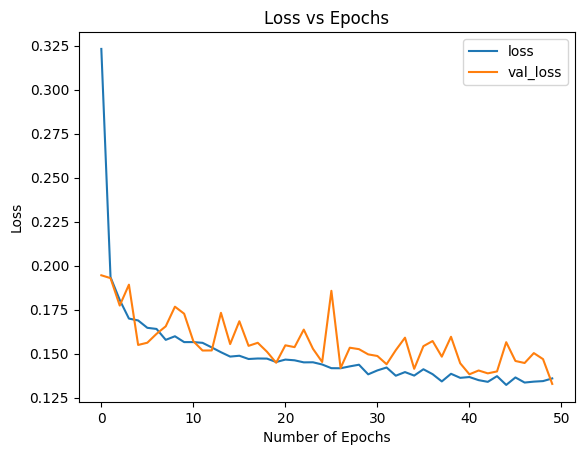

In [18]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsRn50.png')
plt.show()

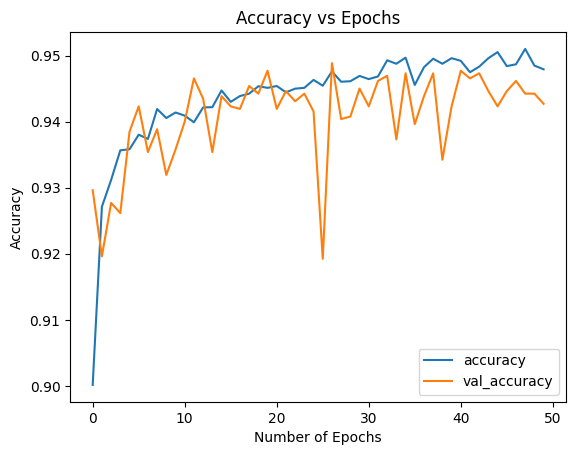

In [19]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsRn50.png')
plt.show()

In [20]:
predictions = resnet_model.predict(test_image_gen)

82/82 [==============================] - 8s 91ms/step


In [21]:
predictions = predictions >= 0.5

In [22]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [23]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1221,   79],
       [  52, 1248]], dtype=int64)

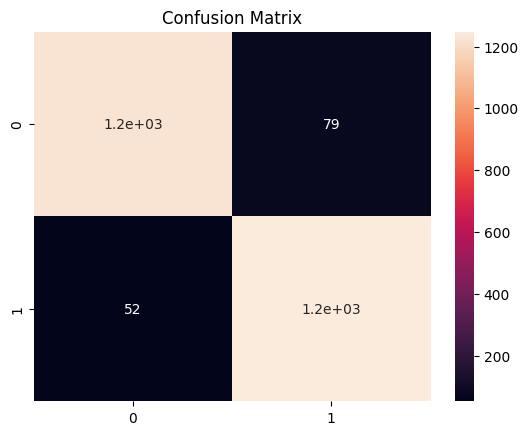

In [24]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapRn50.png')
plt.show()

In [25]:
resnet_model.save("MalariaPredictionsRn50.h5")